## import packages

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## remove stopwords
## we will replace this word list with our own list

In [6]:
#Prepare Stopwords
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## import data

In [10]:
# Import Dataset
df = pd.read_csv('lyricsByYear.csv',sep='\t')
df

,Unnamed: 0,Year,CombinedLyrics
0,0,2000,i can feel the magic floating in the air bein...
1,1,2001,im desperate for changing starving for truth ...
2,2,2002,never made it as a wise man i couldnt cut it ...
3,3,2003,go go go go go go go shawty its your birthday...
4,4,2004,peace up atown down yeah ok lil jonyeah yeah ...
5,5,2005,ooh ooh sweet love yeahi didnt mean it when i...
6,6,2006,where is the moment when we needed the most y...
7,7,2007,to the left to the left everything you own in ...
8,8,2008,shawty had them apple bottom jeans jeans boot...
9,9,2009,gotta getget gotta getget gotta getget gotta g...


In [12]:
# Convert to list
data = df.CombinedLyrics.values.tolist()
#pprint(data[:1])

Tokenize words and Clean-up text
- tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
- Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])

Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.
- Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. 
- The higher the values of these param, the harder it is for words to be combined to bigrams.

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

Remove Stopwords, Make Bigrams and Lemmatize
- define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [21]:
id2word[0]

'able'

## find the best k

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

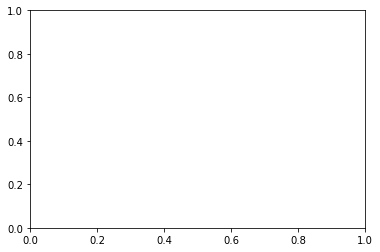

In [41]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

View a human-readable form of the corpus itself

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('account', 1),
  ('always', 1),
  ('atmosphere', 1),
  ('attract', 1),
  ('authentic', 1),
  ('authority', 1),
  ('character', 1),
  ('eighteenth_century', 1),
  ('entertain', 1),
  ('general', 1),
  ('life', 1),
  ('little', 1),
  ('manner', 1),
  ('perhaps', 1),
  ('present', 1),
  ('quote', 1),
  ('read', 1),
  ('reader', 1),
  ('sketchy', 1),
  ('source', 1),
  ('stimulating', 1),
  ('strange', 1),
  ('write', 1)]]

In addition to the corpus and dictionary, you need to provide the number of topics.

- Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

- chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"homely" + 0.033*"hospitality" + 0.032*"unforeseen" + 0.015*"leg" + '
  '0.014*"couple" + 0.014*"engrave" + 0.013*"criminal" + 0.012*"environment" + '
  '0.011*"gossip" + 0.011*"police"'),
 (1,
  '0.038*"hair" + 0.015*"sinclair" + 0.010*"furniture" + 0.010*"exploit" + '
  '0.009*"doing" + 0.008*"box" + 0.008*"lone" + 0.007*"generously" + '
  '0.007*"tilt" + 0.005*"amplify"'),
 (2,
  '0.102*"charm" + 0.032*"indian" + 0.015*"gallery" + 0.011*"nervous" + '
  '0.011*"logical" + 0.010*"award" + 0.009*"sculptor" + 0.008*"egyptian" + '
  '0.007*"project" + 0.007*"sturdy"'),
 (3,
  '0.039*"play" + 0.033*"art" + 0.021*"poet" + 0.021*"verse" + 0.020*"poem" + '
  '0.020*"poetry" + 0.016*"music" + 0.014*"beauty" + 0.013*"artist" + '
  '0.013*"stage"'),
 (4,
  '0.017*"properly" + 0.017*"fascinate" + 0.016*"regular" + '
  '0.013*"exaggeration" + 0.007*"scarlet" + 0.004*"vivacity" + 0.004*"wagner" '
  '+ 0.003*"fetch" + 0.002*"unspoiled" + 0.001*"erudite"'),
 (5,
  '0.015*"condition" + 

Compute Model Perplexity and Coherence Score
- Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
- a quick explanation: https://rare-technologies.com/what-is-topic-coherence/
- a paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.609682081003106

Coherence Score:  0.4860063025049396


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds='mmds')
vis


/Users/hu/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.476566 -0.127363       1        1  46.454880
15    -0.501331  0.074955       2        1  33.822914
3     -0.029252 -0.463538       3        1   6.608131
18    -0.302325 -0.336585       4        1   6.014164
5     -0.225659  0.381865       5        1   4.778449
11     0.047442  0.247144       6        1   0.811740
0     -0.028968  0.034860       7        1   0.369625
2      0.094051 -0.075657       8        1   0.265370
8      0.188261 -0.049897       9        1   0.186185
7      0.154806  0.010324      10        1   0.123126
1      0.149364  0.052779      11        1   0.112441
12     0.113434  0.066117      12        1   0.097522
14     0.085259  0.002493      13        1   0.087381
4      0.118372  0.038955      14        1   0.068780
9      0.088136  0.027920      15        1   0.051294
16     0.095789  0.041161      16        1   0.049851
6      0.112853  0.005661      17        1   0.049446
19     0.108493  0.021465      18        1   0.026185
17     0.103058  0.023010      19        1   0.017675
10     0.104787  0.024332      20        1   0.004840, topic_info=      Category         Freq         Term        Total  loglift  logprob
283    Default  1254.000000         play  1254.000000  30.0000  30.0000
381    Default  3071.000000        story  3071.000000  29.0000  29.0000
1979   Default  1110.000000          art  1110.000000  28.0000  28.0000
2031   Default   882.000000     religion   882.000000  27.0000  27.0000
439    Default  2421.000000         work  2421.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
11889  Topic20     0.000637      uttered     0.520581   3.2306 -10.4809
11890  Topic20     0.000637         weed     0.520581   3.2306 -10.4809
11891  Topic20     0.000637  advertising     0.520581   3.2306 -10.4809
11892  Topic20     0.000637   cheapening     0.520580   3.2306 -10.4809
11893  Topic20     0.000637   externally     0.520581   3.2306 -10.4809

[2120 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3629      4  0.999355      accord
600       7  0.914066  accurately
446       3  0.992605       actor
2901      1  0.083763       admit
2901      4  0.915187       admit
...     ...       ...         ...
443       1  0.631953        year
443       2  0.363658        year
443       5  0.004270        year
855       1  0.028931       young
855       2  0.970032       young

[709 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 4, 19, 6, 12, 1, 3, 9, 8, 2, 13, 15, 5, 10, 17, 7, 20, 18, 11])

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

- A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

- if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

- Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. 

In [16]:
# Building LDA Mallet Model
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/hu/Desktop/BPO2019fall/TM3/mallet-2.0.8/bin/mallet'# update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('play', 0.05440346155875679),
   ('make', 0.01947126800696533),
   ('stage', 0.016780117144214027),
   ('good', 0.014194501609413752),
   ('work', 0.013561289641707561),
   ('give', 0.01245316869822173),
   ('scene', 0.012136562714368635),
   ('part', 0.011608886074613477),
   ('drama', 0.011503350746662444),
   ('act', 0.010236926811250066)]),
 (1,
  [('man', 0.0438886267107126),
   ('life', 0.04365266635205285),
   ('live', 0.02449268522888155),
   ('thing', 0.024445493157149598),
   ('love', 0.020434167059933932),
   ('world', 0.019301557338367154),
   ('make', 0.019254365266635206),
   ('find', 0.01651722510618216),
   ('heart', 0.016234072675790467),
   ('feel', 0.010571024067956583)]),
 (2,
  [('story', 0.1312460649075611),
   ('reader', 0.02072005036918322),
   ('character', 0.016541697670425275),
   ('tale', 0.016083796004807967),
   ('romance', 0.015797607463797148),
   ('mystery', 0.013851525384923588),
   ('end', 0.013508099135710607),
   ('author', 0.01161925476503

However, here afterchanging the LDA algorithm, the coherence score dropeed from .48 to .38.

To find the optimal number of topics for LDA?
- build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

- Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

- If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

- The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

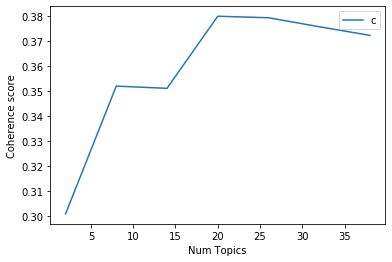

In [20]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps, here we choose the model with 20 topics (exactlt what we have gotten).

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3008
Num Topics = 8  has Coherence Value of 0.352
Num Topics = 14  has Coherence Value of 0.3511
Num Topics = 20  has Coherence Value of 0.38
Num Topics = 26  has Coherence Value of 0.3794
Num Topics = 32  has Coherence Value of 0.3758
Num Topics = 38  has Coherence Value of 0.3723


Below are the topics for the chosen LDA model.

In [22]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"history" + 0.035*"great" + 0.017*"period" + 0.015*"present" + '
  '0.014*"early" + 0.013*"volume" + 0.011*"give" + 0.011*"time" + '
  '0.011*"historical" + 0.011*"page"'),
 (1,
  '0.035*"thing" + 0.025*"good" + 0.023*"man" + 0.022*"turn" + 0.020*"young" + '
  '0.017*"people" + 0.013*"talk" + 0.011*"call" + 0.011*"bad" + '
  '0.010*"moment"'),
 (2,
  '0.028*"war" + 0.023*"make" + 0.017*"great" + 0.014*"time" + 0.014*"german" '
  '+ 0.012*"year" + 0.009*"man" + 0.009*"leave" + 0.008*"peace" + '
  '0.008*"fight"'),
 (3,
  '0.027*"book" + 0.020*"interesting" + 0.020*"make" + 0.019*"chapter" + '
  '0.019*"case" + 0.017*"school" + 0.016*"give" + 0.016*"fact" + 0.013*"study" '
  '+ 0.010*"bring"'),
 (4,
  '0.020*"man" + 0.015*"make" + 0.014*"find" + 0.013*"time" + 0.013*"day" + '
  '0.010*"fall" + 0.008*"eye" + 0.008*"dead" + 0.007*"night" + 0.007*"water"'),
 (5,
  '0.097*"book" + 0.053*"write" + 0.038*"read" + 0.034*"make" + 0.034*"author" '
  '+ 0.028*"good" + 0.020*"life" + 

Finding the dominant topic in each sentence
- One of the practical application of topic modeling is to determine what topic a given document is about.

- To find that, we find the topic number that has the highest percentage contribution in that document.

- The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1056,"history, great, period, present, early, volume...",stonge htrory lord george gordon percy colmon ...
1,1,13.0,0.2698,"write, letter, friend, time, great, long, die,...",shakespeare seventeenth century manuscript e m...
2,2,10.0,0.2846,"end, mystery, murder, part, real, lie, follow,...",shakespeare sonnet edward de vere gerald h ren...
3,3,11.0,0.1355,"poet, poem, poetry, music, write, word, verse,...",shakespeare music denit pworoemsh tmwx sout k...
4,4,3.0,0.1185,"book, interesting, make, chapter, case, school...",waiting city abridg ment louis sebastien merci...
5,5,15.0,0.1453,"play, make, stage, good, give, part, scene, dr...",new edition twelfth night edited sir arthur qu...
6,6,13.0,0.1214,"write, letter, friend, time, great, long, die,...",parable lover lewis gibbs 7 6d dent we heard l...
7,7,14.0,0.1375,"country, give, work, interest, describe, pictu...",dzoa lovzse john c moore dent 75 6d mr moore f...
8,8,2.0,0.3510,"war, make, great, time, german, year, man, lea...",air raid war air vol iii h a jones 7 6d milfor...
9,9,9.0,0.1347,"book, volume, author, publish, work, year, num...",first lord cowley wellington brother diary cor...


Find the most representative document for each topic
- Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 
- To help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [24]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2749,"history, great, period, present, early, volume...",annals south africa eistory south africa 18731...
1,1.0,0.2883,"thing, good, man, turn, young, people, talk, c...",immortal jane mary webb mr h b l webb must be ...
2,2.0,0.4725,"war, make, great, time, german, year, man, lea...",war airand butcher shop save fact common denom...
3,3.0,0.6302,"book, interesting, make, chapter, case, school...",inner life pauper asylum dr montagu lomax engl...
4,4.0,0.5418,"man, make, find, time, day, fall, eye, dead, n...",tree god t f powys mr told great man farmed l...


Topic distribution across documents
- To understand the volume and distribution of topics in order to judge how widely it was discussed. 
- The below table exposes that information.

In [25]:
#Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"history, great, period, present, early, volume...",143.0,0.0510
1.0,13.0,"write, letter, friend, time, great, long, die,...",100.0,0.0357
2.0,10.0,"end, mystery, murder, part, real, lie, follow,...",124.0,0.0442
3.0,11.0,"poet, poem, poetry, music, write, word, verse,...",73.0,0.0260
4.0,3.0,"book, interesting, make, chapter, case, school...",124.0,0.0442
...,...,...,...,...
2800.0,13.0,"write, letter, friend, time, great, long, die,...",NaN,NaN
2801.0,8.0,"child, book, picture, colour, illustration, fi...",NaN,NaN
2802.0,12.0,"woman, life, love, young, family, wife, mother...",NaN,NaN
2803.0,6.0,"man, life, world, human, religion, truth, mind...",NaN,NaN


In [ ]:
N